In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv3D, Activation, BatchNormalization, ZeroPadding3D, Subtract
from tensorflow.keras.losses import MeanSquaredError
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import os

 

In [2]:
### ===== Read Data ====== ###
ROOT_PATH = './data'
FILE_NAME_NOISY = 'tgtnz_img.npy'
FILE_NAME_TRUE  = 'tgt_img.npy'
EVAL_DATA_PCT = 0.2
N_EPOCHS = 6
BATCH_SIZE = 4
DIM = [146,120,36]
N_CHANNELS = 8

# Get filepaths for noisy/true images
#   iterative DFS
stack, filepaths_noisy, filepaths_true = [ROOT_PATH], [], []
while stack:
    p = stack.pop()
    psubs = os.listdir(p)
    if os.path.isdir(os.path.join(p,psubs[0])):
        stack += [os.path.join(p,psub) for psub in psubs]
    else:
        for filename in psubs:
            if filename == FILE_NAME_NOISY:
                filepaths_noisy.append(os.path.join(p,filename))
            else: # filename == FILE_NAME_TRUE
                filepaths_true.append(os.path.join(p,filename))


# Data splitting into train/eval
#   choose EVAL_DATA_PCT ratio of data for evaluation, rest for training
n_data = len(filepaths_noisy)
idx_data_valid = np.random.choice(n_data, int(np.floor(n_data * EVAL_DATA_PCT)), replace=False)
idx_data_train = np.setdiff1d(np.arange(n_data), idx_data_valid)





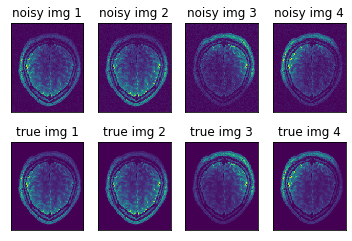

In [3]:
### ===== Demo Images ===== ###
DATA_NUM = 1
SLICE_NUM = 20


imgnz = np.load(filepaths_noisy[DATA_NUM]) 
img   = np.load(filepaths_true[DATA_NUM]) 
plt.figure()
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.xticks([]); plt.yticks([]); plt.title('noisy img ' + str(i+1))
    plt.imshow(np.abs(imgnz[:,:,SLICE_NUM,i]))
    plt.subplot(2,4,i+5)
    plt.xticks([]); plt.yticks([]); plt.title('true img ' + str(i+1))
    plt.imshow(np.abs(img[:,:,SLICE_NUM,i]))



In [4]:
### ====== Batch Generator ===== ###
class VoxelDataGenerator(tf.keras.utils.Sequence):
    # Generator of the small batches
    #    shuffle data each epoch, random shift the voxels while generating
    
    def __init__(self, filepaths_noisy, filepaths_true, batch_size=16, dim=(64,64,64),
                 n_channels=1, shuffle=False, shift_range=(0,0,0)):
        self.filepaths_noisy = filepaths_noisy 
        self.filepaths_true = filepaths_true
        self.n_data = len(filepaths_noisy)
        self.batch_size = batch_size
        self.dim = np.array(dim)
        self.n_channels = n_channels
        
        self.shuffle = shuffle
        self.shift_range = np.array(shift_range)
        
        self.idx_data = np.arange(self.n_data)
        self.on_epoch_end()
        
    def __len__(self):
        # Return number of batches per epoch
        return int( len(self.filepaths_noisy) // self.batch_size )

    def __getitem__(self, i):
        # Return a batch of training data pair.
        #    for each image, we randomly shift and double the channle for real/imaginary components
        idx_batch = self.idx_data[i * self.batch_size : (i+1) * self.batch_size] 
        filepaths_noisy_batch = [self.filepaths_noisy[j] for j in idx_batch]
        filepaths_true_batch = [self.filepaths_true[j] for j in idx_batch]
        
        def cat_ri(vec):
            return np.concatenate((np.real(vec), np.imag(vec)), axis=3)
        
        def shift(vec,s):
            for c in range(2*self.n_channels):
                vec[:,:,:,c] = ndi.shift(vec[:,:,:,c], shift_dist)
            return vec
        
        shift_dist = self.dim * self.shift_range * (2*np.random.rand(3)-1)/2
        return np.array([shift(cat_ri(np.load(fp)), shift_dist) for fp in filepaths_noisy_batch]),\
               np.array([shift(cat_ri(np.load(fp)), shift_dist) for fp in filepaths_true_batch]) 

    def on_epoch_end(self):
        # Shuffle data index each epoch
        if self.shuffle:
            np.random.shuffle(self.idx_data)

# Generator, training data
generator_train = VoxelDataGenerator(
                    filepaths_noisy = np.array(filepaths_noisy)[idx_data_train],
                    filepaths_true = np.array(filepaths_true)[idx_data_train],
                    batch_size = BATCH_SIZE,
                    dim = DIM,
                    n_channels = N_CHANNELS,
                    shuffle = True,
                    shift_range = (0.1,0.1,0.1))

# Generator, validation data
generator_valid = VoxelDataGenerator(
                    filepaths_noisy = np.array(filepaths_noisy)[idx_data_valid],
                    filepaths_true = np.array(filepaths_true)[idx_data_valid],
                    batch_size = BATCH_SIZE,
                    dim = DIM,
                    n_channels = N_CHANNELS)


In [5]:
### ====== Demo Batch Generator ===== ###
# DATA_NUM = 1
# SLICE_NUM = 20

# it = iter(generator_valid)
# A1, A2 = next(it)
# print('Shape of patch:', A1.shape)

# for i in range(4):
#     plt.subplot(2,4,i+1)
#     plt.xticks([]); plt.yticks([]); plt.title('noisy img ' + str(i+1))
#     plt.imshow(A1[DATA_NUM,:,:,SLICE_NUM,i])
#     plt.subplot(2,4,i+5)
#     plt.xticks([]); plt.yticks([]); plt.title('true img ' + str(i+1))
#     plt.imshow(A2[DATA_NUM,:,:,SLICE_NUM,i])


In [6]:
### ===== Construct DnCNN ====== ###
DEPTH = 10

modelD = Sequential()
modelD.add(Conv3D(16, 3, input_shape=(146,120,36,16), padding='same', data_format='channels_last'))
modelD.add(Activation('relu') )
for _ in range(DEPTH):
    modelD.add(Conv3D(16, 3, padding='same', data_format='channels_last'))
    modelD.add(BatchNormalization(trainable = True))
    modelD.add(Activation('relu'))
modelD.add(Conv3D(16, 3, padding='same', data_format='channels_last'))


modelD.compile(optimizer='adam',
              loss='mean_squared_error')


In [7]:
### ===== Training of DnCNN ====== ###

historyD = modelD.fit_generator(
    generator_train,
    steps_per_epoch = int(len(idx_data_train) // BATCH_SIZE),
    epochs = N_EPOCHS,
    validation_data = generator_valid,
    validation_steps = int(len(idx_data_valid) // BATCH_SIZE)
)

# modelD.save('DnCNN.model')

Epoch 1/6
36/36 [==============================] - 1893s 53s/step - loss: 0.0689 - val_loss: 0.2374
Epoch 2/6
36/36 [==============================] - 1400s 39s/step - loss: 0.0073 - val_loss: 0.0061
Epoch 3/6
36/36 [==============================] - 1418s 39s/step - loss: 0.0056 - val_loss: 0.0054
Epoch 4/6
36/36 [==============================] - 1418s 39s/step - loss: 0.0051 - val_loss: 0.0053
Epoch 5/6
36/36 [==============================] - 1406s 39s/step - loss: 0.0050 - val_loss: 0.0053
Epoch 6/6
36/36 [==============================] - 1414s 39s/step - loss: 0.0049 - val_loss: 0.0053


4/1 [========================================================================================================================] - 1s 170ms/sample - loss: 0.0044
0.00439643105052559


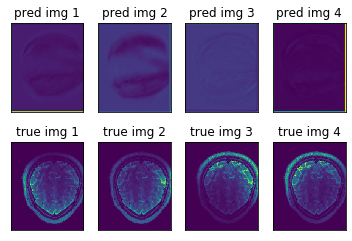

In [95]:
### ===== Demo DnCNN ====== ###
it = iter(generator_valid)
Anz, Acl = next(it)

Apred = modelD.predict(Anz)

for i in range(4):
    plt.subplot(2,4,i+1)
    plt.xticks([]); plt.yticks([]); plt.title('pred img ' + str(i+1))
    plt.imshow(np.abs(Apred[DATA_NUM,:,:,SLICE_NUM,i] + Apred[DATA_NUM,:,:,SLICE_NUM,i+8]*1j))
    plt.subplot(2,4,i+5)
    plt.xticks([]); plt.yticks([]); plt.title('true img ' + str(i+1))
    plt.imshow(np.abs(Acl[DATA_NUM,:,:,SLICE_NUM,i] + Acl[DATA_NUM,:,:,SLICE_NUM,i+8]*1j))
    
evaluate = modelD.evaluate(Anz,Acl)
print(np.sum((Apred - Acl)**2)/(np.prod(Apred.shape)))


In [79]:
### ===== Construct DnUnet ====== ###
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, MaxPool3D, Concatenate, Conv3DTranspose, ZeroPadding3D, Cropping3D


inputs = Input(shape=(146,120,36,16), batch_size=BATCH_SIZE)
L0 = ZeroPadding3D(padding=(7, 4, 6), data_format='channels_last')(inputs)

L1 = Conv3D(16, 3, padding='same', data_format='channels_last', activation='relu')(L0)
L1 = Conv3D(16, 3, padding='same', data_format='channels_last', activation='relu')(L1)

L2 = MaxPool3D(pool_size=(3,3,3), strides=(2,2,2), padding="same", data_format='channels_last')(L1)
L2 = Conv3D(32, 3, padding='same', data_format='channels_last', activation='relu')(L2)
L2 = Conv3D(32, 3, padding='same', data_format='channels_last', activation='relu')(L2)

L3 = MaxPool3D(pool_size=(3,3,3), strides=(2,2,2), padding="same", data_format='channels_last')(L2)
L3 = Conv3D(64, 3, padding='same', data_format='channels_last', activation='relu')(L3)
L3 = Conv3D(64, 3, padding='same', data_format='channels_last', activation='relu')(L3)

L4 = MaxPool3D(pool_size=(3,3,3), strides=(2,2,2), padding="same", data_format='channels_last')(L3)
L4 = Conv3D(128, 3, padding='same', data_format='channels_last', activation='relu')(L4)
L4 = Conv3D(128, 3, padding='same', data_format='channels_last', activation='relu')(L4)
L4 = Conv3DTranspose(64, 3, padding='same', strides=(2,2,2), data_format='channels_last')(L4)

L5 = Concatenate()([L3,L4])

L5 = Conv3D(64, 3, padding='same', data_format='channels_last', activation='relu')(L5)
L5 = Conv3D(64, 3, padding='same', data_format='channels_last', activation='relu')(L5)
L5 = Conv3DTranspose(32, 3, padding='same', strides=(2,2,2), data_format='channels_last')(L5)

L6 = Concatenate()([L2,L5])

L6 = Conv3D(32, 3, padding='same', data_format='channels_last', activation='relu')(L6)
L6 = Conv3D(32, 3, padding='same', data_format='channels_last', activation='relu')(L6)
L6 = Conv3DTranspose(16, 3, padding='same', strides=(2,2,2), data_format='channels_last')(L6)

L7 = Concatenate()([L1,L6])

L7 = Conv3D(16, 3, padding='same', data_format='channels_last', activation='relu')(L7)
L7 = Conv3D(16, 3, padding='same', data_format='channels_last')(L7)

outputs = Cropping3D((7,4,6), data_format='channels_last')(L7)

modelU = tf.keras.Model(inputs=inputs, outputs=outputs)

modelU.compile(optimizer='adam',
              loss='mean_squared_error')


In [80]:
### ===== Training of DnUnet ====== ###
historyU = modelU.fit_generator(
    generator_train,
    steps_per_epoch = int(len(idx_data_train) // BATCH_SIZE),
    epochs = N_EPOCHS,
    validation_data = generator_valid,
    validation_steps = int(len(idx_data_valid) // BATCH_SIZE)
)

# modelU.save('DnUnet.model')

Epoch 1/6
36/36 [==============================] - 1817s 50s/step - loss: 0.0039 - val_loss: 0.0036
Epoch 2/6
36/36 [==============================] - 1422s 39s/step - loss: 0.0028 - val_loss: 0.0028
Epoch 3/6
36/36 [==============================] - 1404s 39s/step - loss: 0.0023 - val_loss: 0.0025
Epoch 4/6
36/36 [==============================] - 1408s 39s/step - loss: 0.0021 - val_loss: 0.0023
Epoch 5/6
36/36 [==============================] - 1413s 39s/step - loss: 0.0019 - val_loss: 0.0022
Epoch 6/6
36/36 [==============================] - 1400s 39s/step - loss: 0.0018 - val_loss: 0.0021


4/1 [========================================================================================================================] - 1s 228ms/sample - loss: 0.0016
0.0015736304582647115


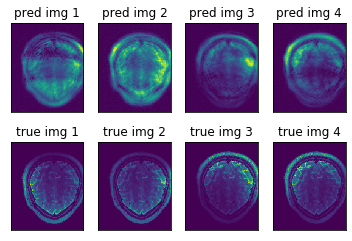

In [96]:
### ===== Demo DnUnet ====== ###
it = iter(generator_valid)
Anz, Acl = next(it)

Apred = modelU.predict(Anz)

for i in range(4):
    plt.subplot(2,4,i+1)
    plt.xticks([]); plt.yticks([]); plt.title('pred img ' + str(i+1))
    plt.imshow(np.abs(Apred[DATA_NUM,:,:,SLICE_NUM,i] + Apred[DATA_NUM,:,:,SLICE_NUM,i+8]*1j))
    plt.subplot(2,4,i+5)
    plt.xticks([]); plt.yticks([]); plt.title('true img ' + str(i+1))
    plt.imshow(np.abs(Acl[DATA_NUM,:,:,SLICE_NUM,i] + Acl[DATA_NUM,:,:,SLICE_NUM,i+8]*1j))
    
evaluate = modelU.evaluate(Anz,Acl)
print(np.sum((Apred - Acl)**2)/(np.prod(Apred.shape)))

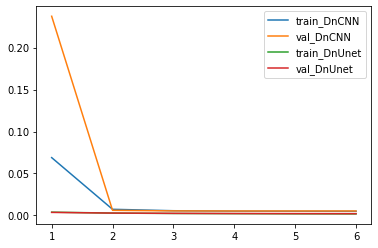

In [114]:
loss_train_d = [0.0689, 0.0073, 0.0056, 0.0051, 0.0050, 0.0049]
loss_val_d = [0.2374, 0.0061, 0.0054, 0.0053, 0.0053, 0.0053]
loss_train_u = [0.0039, 0.0028, 0.0023, 0.0021, 0.0019, 0.0018]
loss_val_u = [0.0036, 0.0028, 0.0025, 0.0023, 0.0022, 0.0021]
epochs = np.arange(1,7)

plt.figure()
plt.plot(epochs, loss_train_d); 
plt.plot(epochs, loss_val_d); 
plt.plot(epochs, loss_train_u)
plt.plot(epochs, loss_val_u)
plt.legend(['train_DnCNN', 'val_DnCNN', 'train_DnUnet', 'val_DnUnet'])
